In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import utils
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve



In [2]:
# Descargar el dataset desde Kaggle
path = kagglehub.dataset_download("mirichoi0218/insurance")

# Cargar el archivo CSV en un DataFrame
dataset_path = f"{path}/insurance.csv"
data = pd.read_csv(dataset_path)


In [3]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [6]:
data.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [7]:
# Identificar duplicados
duplicados = data.duplicated()
# Contar el número de duplicados
num_duplicados = duplicados.sum()
print(f"Número de registros duplicados: {num_duplicados}")
data.loc[duplicados].head(3)

Número de registros duplicados: 1


,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


Eliminamos los duplicados

In [8]:
data = data.drop_duplicates() # Eliminar duplicados

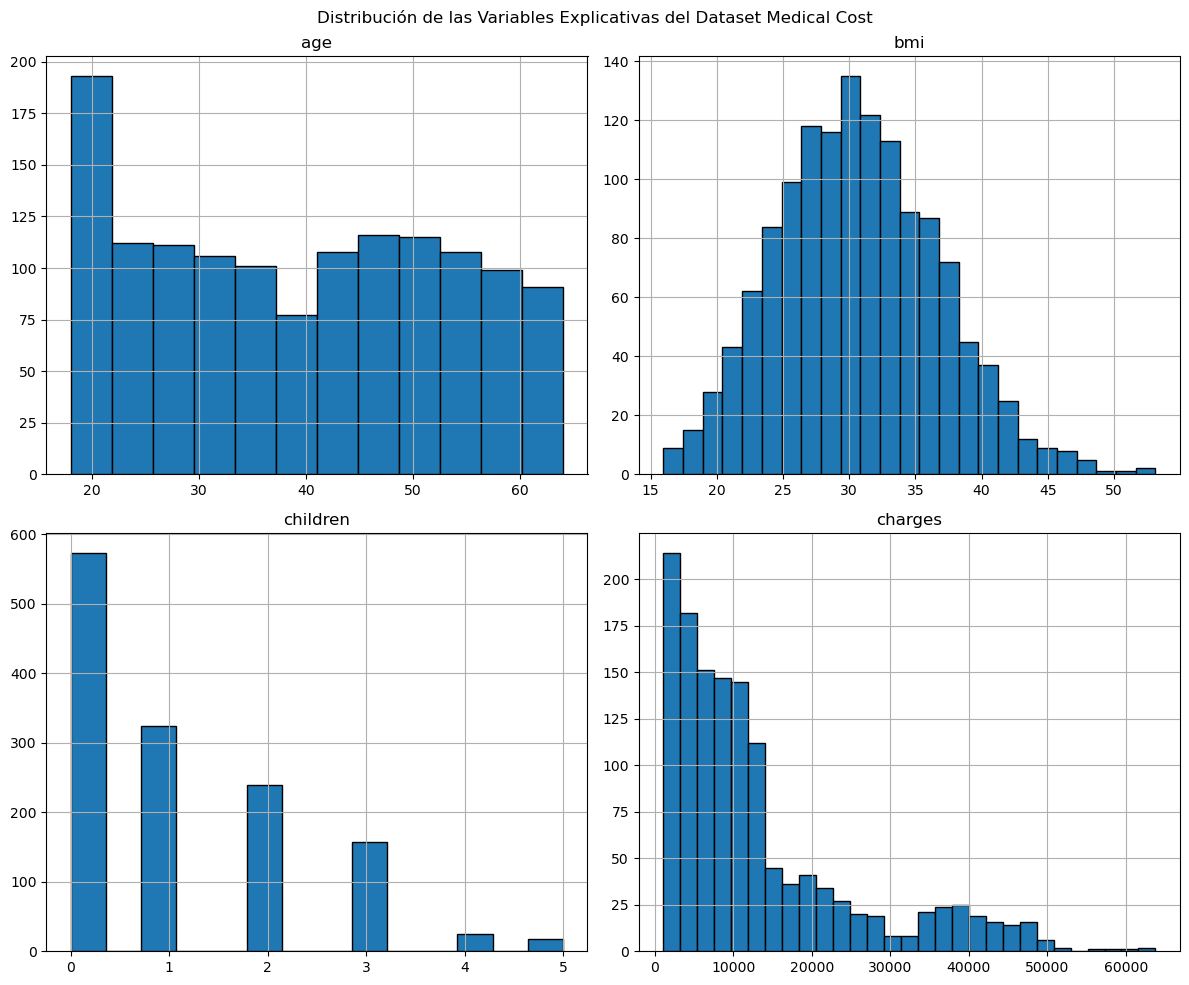

In [9]:
# Crear histogramas para cada característica
data.hist(bins='auto', figsize=(12, 10), edgecolor='black')
plt.suptitle('Distribución de las Variables Explicativas del Dataset Medical Cost')
plt.tight_layout()
plt.show()

In [10]:
data

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [11]:
data2 = data.copy()

In [12]:
data2['smoker'] = data2['smoker'].map({'yes': True, 'no': False})

In [13]:
data_dict = {
    'age': 'int64',
    'sex': 'category',
    'bmi': 'float64',
    'children': 'int64',
    'smoker': 'bool',
    'region': 'category',
    'charges': 'float64'
}

# Convertir tipos de datos según el diccionario
for column, dtype in data_dict.items():
    data2[column] = data2[column].astype(dtype, errors='ignore')
data2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1337 non-null   int64   
 1   sex       1337 non-null   category
 2   bmi       1337 non-null   float64 
 3   children  1337 non-null   int64   
 4   smoker    1337 non-null   bool    
 5   region    1337 non-null   category
 6   charges   1337 non-null   float64 
dtypes: bool(1), category(2), float64(2), int64(2)
memory usage: 56.5 KB


Consistencia en valores categoricos

In [14]:
boolean_columns = data2.select_dtypes(include=['bool'])
boolean_columns.head()

,smoker
0,True
1,False
2,False
3,False
4,False


In [15]:
categorical_columns = data2.select_dtypes(include=['category'])

In [16]:
for col in categorical_columns:
    categorical_columns[col] = categorical_columns[col].apply(utils.limpiar_cadena)
# Verificar los cambios
for col in categorical_columns:
    print(f"\nValores únicos después de limpieza en '{col}':")
    print(categorical_columns[col].unique())


Valores únicos después de limpieza en 'sex':
['female', 'male']
Categories (2, object): ['female', 'male']

Valores únicos después de limpieza en 'region':
['southwest', 'southeast', 'northwest', 'northeast']
Categories (4, object): ['northeast', 'northwest', 'southeast', 'southwest']


Columnas numericas

In [17]:
numerical_columns = data.select_dtypes(include=[np.number])

In [18]:
utils.calculate_na_statistics(numerical_columns)

,datos sin NAs en q,Na en q,Na en %
age,1337,0,0.0
bmi,1337,0,0.0
children,1337,0,0.0
charges,1337,0,0.0


In [19]:
# Create a summary DataFrame for outliers
outliers_summary = pd.DataFrame()
for column in numerical_columns:
    outliers = utils.detect_outliers_iqr(data[column])
    outliers_summary[column] = {
        'Number of Outliers': outliers.sum(),
        'Percentage of Outliers': 100 * outliers.mean(),
        'Lower Bound': data[column][~outliers].min(),
        'Upper Bound': data[column][~outliers].max()
    }

# Save the summary to a CSV file
outliers_summary.T

,Number of Outliers,Percentage of Outliers,Lower Bound,Upper Bound
age,0.0,0.000000,18.0000,64.000
bmi,9.0,0.673149,15.9600,46.750
children,0.0,0.000000,0.0000,5.000
charges,139.0,10.396410,1121.8739,34472.841


In [20]:
# Crear un diccionario para almacenar las estadísticas
estadisticas_dict = {}
# Iterar sobre cada columna numérica y calcular las estadísticas
for columna in numerical_columns:
    datos_columna = data[columna].values
    estadisticas = utils.calcular_estadisticas(columna, datos_columna)
    estadisticas_dict[columna] = estadisticas
# Convertir el diccionario a un DataFrame para una mejor visualización
estadisticas_df = pd.DataFrame(estadisticas_dict).T  # Transponer para que las columnas sean las filas
estadisticas_df = estadisticas_df[['Cuenta', 'Media', 'Mediana', 'Desviación Estándar', 
                                   'Mínimo', 'Máximo', '25% Percentil', '75% Percentil']]
# Redondear las estadísticas a 2 decimales
estadisticas_df = estadisticas_df.round(2)
# Mostrar el DataFrame formateado
print("\nEstadísticas Descriptivas (Redondeadas a 2 decimales):")
estadisticas_df


Estadísticas Descriptivas (Redondeadas a 2 decimales):


,Cuenta,Media,Mediana,Desviación Estándar,Mínimo,Máximo,25% Percentil,75% Percentil
age,1337.0,39.22,39.00,14.04,18.00,64.00,27.00,51.00
bmi,1337.0,30.66,30.40,6.10,15.96,53.13,26.29,34.70
children,1337.0,1.10,1.00,1.21,0.00,5.00,0.00,2.00
charges,1337.0,13279.12,9386.16,12110.36,1121.87,63770.43,4746.34,16657.72


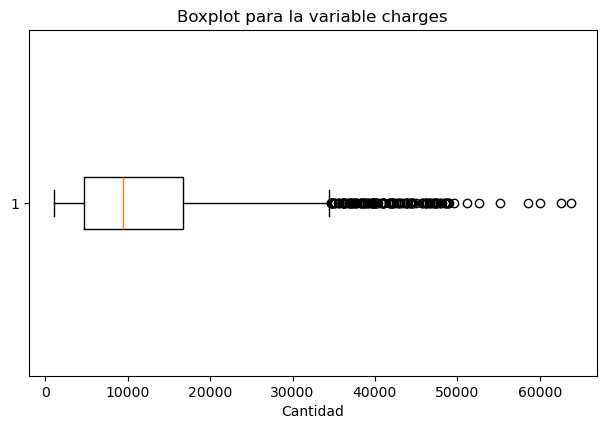

In [21]:
# Identify columns with more than 5% of outliers
columns_with_outliers = outliers_summary.columns[outliers_summary.loc['Percentage of Outliers'] > 5]
# Filter the original DataFrame to include only these columns
df_outliers = data[columns_with_outliers]
# Create separate box plots for each column with more than 5% outliers in a 2x2 grid
plt.figure(figsize=(12, 8))
for i, column in enumerate(columns_with_outliers, 1):
    plt.subplot(2, 2, i)
    plt.boxplot(df_outliers[column].dropna(), vert=False)
    plt.title(f"Boxplot para la variable {column}")
    plt.xlabel("Cantidad")
plt.tight_layout()
plt.show()


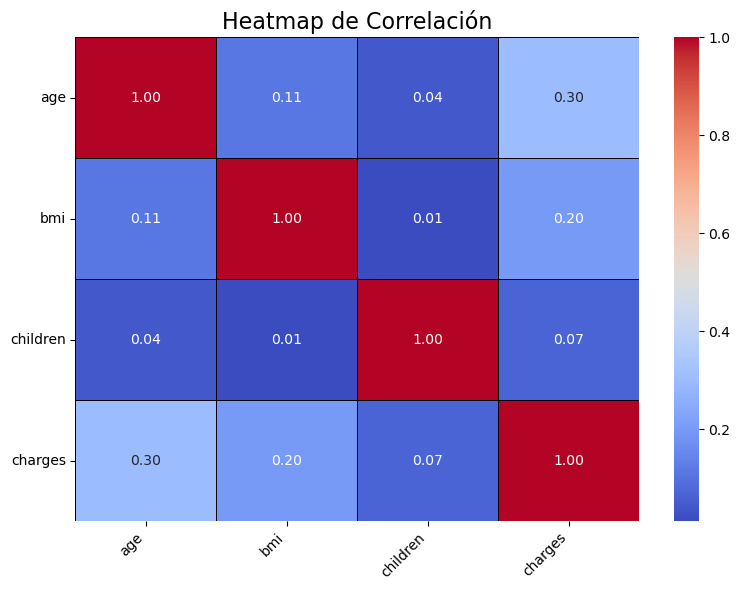

In [22]:
# Crear la figura y el heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(numerical_columns.corr(), annot=True  ,fmt=".2f", cmap='coolwarm', linewidths=0.5, linecolor='black')

# Agregar título y ajustar el diseño
plt.title('Heatmap de Correlación', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Mostrar el gráfico
plt.tight_layout
plt.show()

Text(0, 0.5, 'Features')

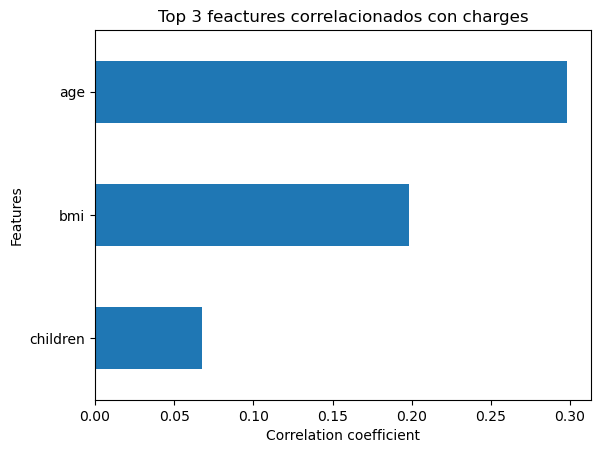

In [23]:
plt.figure()
numerical_columns.corr().charges.apply(lambda x: abs(x)).sort_values(ascending=False).iloc[1:11][::-1].plot(kind='barh') 
plt.title("Top 3 feactures correlacionados con charges")
plt.xlabel("Correlation coefficient")
plt.ylabel("Features")

Modeling

In [24]:
data2.head(20)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,True,southwest,16884.92400
1,18,male,33.770,1,False,southeast,1725.55230
2,28,male,33.000,3,False,southeast,4449.46200
3,33,male,22.705,0,False,northwest,21984.47061
4,32,male,28.880,0,False,northwest,3866.85520
5,31,female,25.740,0,False,southeast,3756.62160
6,46,female,33.440,1,False,southeast,8240.58960
7,37,female,27.740,3,False,northwest,7281.50560
8,37,male,29.830,2,False,northeast,6406.41070
9,60,female,25.840,0,False,northwest,28923.13692


In [25]:
data_clean = pd.concat([numerical_columns, categorical_columns, boolean_columns], axis=1)
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1337 non-null   int64   
 1   bmi       1337 non-null   float64 
 2   children  1337 non-null   int64   
 3   charges   1337 non-null   float64 
 4   sex       1337 non-null   category
 5   region    1337 non-null   category
 6   smoker    1337 non-null   bool    
dtypes: bool(1), category(2), float64(2), int64(2)
memory usage: 56.5 KB


In [26]:
data_clean.head()


,age,bmi,children,charges,sex,region,smoker
0,19,27.900,0,16884.92400,female,southwest,True
1,18,33.770,1,1725.55230,male,southeast,False
2,28,33.000,3,4449.46200,male,southeast,False
3,33,22.705,0,21984.47061,male,northwest,False
4,32,28.880,0,3866.85520,male,northwest,False


In [27]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1337 non-null   int64   
 1   bmi       1337 non-null   float64 
 2   children  1337 non-null   int64   
 3   charges   1337 non-null   float64 
 4   sex       1337 non-null   category
 5   region    1337 non-null   category
 6   smoker    1337 non-null   bool    
dtypes: bool(1), category(2), float64(2), int64(2)
memory usage: 56.5 KB


Modeling

Validación cruzada inicial:
LogisticRegression: 0.9467 ± 0.0155
KNN: 0.9383 ± 0.0054
DecisionTree: 0.9504 ± 0.0150

Optimización de hiperparámetros:
LogisticRegression - Mejor score (GridSearchCV): 0.9467
KNN - Mejor score (GridSearchCV): 0.9420
DecisionTree - Mejor score (GridSearchCV): 0.9617

Evaluación de modelos optimizados:

Modelo: LogisticRegression
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       208
           1       0.93      0.93      0.93        60

    accuracy                           0.97       268
   macro avg       0.96      0.96      0.96       268
weighted avg       0.97      0.97      0.97       268

ROC-AUC: 0.9934
Matriz de confusión:
[[204   4]
 [  4  56]]

Modelo: KNN
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       208
           1       0.92      0.95      0.93        60

    accuracy                           0.97       268
   macro avg       0.9

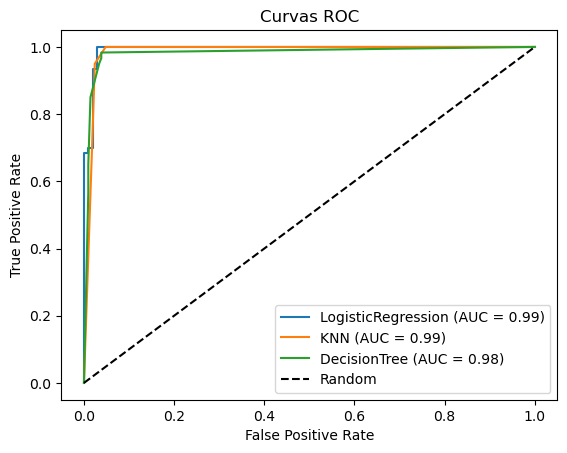

In [28]:
# 1. Preprocesamiento de datos
# Separar características y objetivo
X = data2.drop('smoker', axis=1)
y = data2['smoker'].astype(int)  # Convertir a formato 0 y 1 para clasificación

# Identificar columnas por tipo
num_features = ['age', 'bmi', 'children', 'charges']
cat_features = ['sex', 'region']

# Pipelines de preprocesamiento
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputar valores faltantes
    ('scaler', StandardScaler())                 # Escalar características numéricas
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputar valores categóricos
    ('onehot', OneHotEncoder(drop='first'))                # One-Hot Encoding con eliminación de una categoría
])

# Crear el ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ]
)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelos de clasificación
models = {
    'LogisticRegression': LogisticRegression(),
    'KNN': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier()
}

# Evaluar modelos con validación cruzada
print("Validación cruzada inicial:")
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{name}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

# 2. Optimización de hiperparámetros
# Hiperparámetros para cada modelo
param_grids = {
    'LogisticRegression': {
        'classifier__C': [0.1, 1, 10],
        'classifier__solver': ['liblinear', 'lbfgs']
    },
    'KNN': {
        'classifier__n_neighbors': [3, 5, 7],
        'classifier__weights': ['uniform', 'distance']
    },
    'DecisionTree': {
        'classifier__max_depth': [None, 5, 10, 20],
        'classifier__min_samples_split': [2, 5, 10]
    }
}

# GridSearchCV y RandomizedSearchCV
optimized_models = {}
print("\nOptimización de hiperparámetros:")
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    grid_search = GridSearchCV(pipeline, param_grids[name], cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    optimized_models[name] = grid_search.best_estimator_
    print(f"{name} - Mejor score (GridSearchCV): {grid_search.best_score_:.4f}")

# 3. Evaluación de modelos optimizados
print("\nEvaluación de modelos optimizados:")
for name, model in optimized_models.items():
    y_pred = model.predict(X_test)
    print(f"\nModelo: {name}")
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC: {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]):.4f}")
    cm = confusion_matrix(y_test, y_pred)
    print("Matriz de confusión:")
    print(cm)

    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]):.2f})")

# Visualizar curvas ROC
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC")
plt.legend()
plt.show()
